In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import os,sys
from PIL import Image

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)

In [3]:

n = min(100, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

n = 100 # Only use 10 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


Image size = 400,400


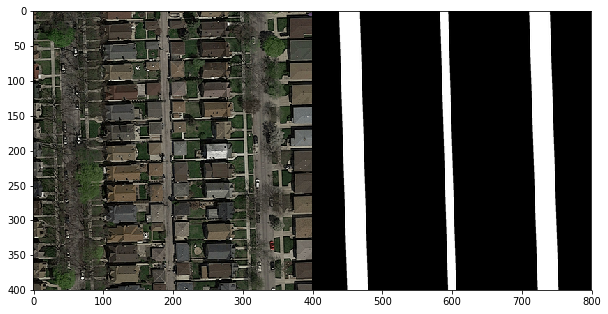

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]
# Linearize list of patches
#shape is 10*625 (10 images, cut up into 625 images with 16*16)
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
img_patches.shape

(62500, 16, 16, 3)

In [6]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
print(X)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

[[0.23097427 0.00935294]
 [0.18094365 0.01722232]
 [0.24829964 0.01547983]
 ...
 [0.2233456  0.01478162]
 [0.20900737 0.02261014]
 [0.25439134 0.00744627]]


In [7]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(set(Y))))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 2
Number of classes = 2
Class 0: 46309 samples
Class 1: 16191 samples


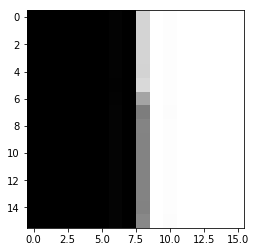

In [8]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

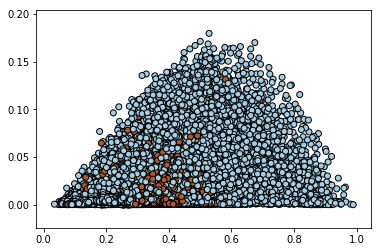

In [9]:
# Plot 2d features using groundtruth to color the datapoints
# Rødt er vei
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [10]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [11]:
def split_data(x, y, ratio, seed=1):
    #select a cutting point based on ratio
    cut = int(round(len(x)*ratio))
    x_test = x[cut:]
    x_train = x[:cut]
    y_test = y[cut:]
    y_train = y[:cut]
    
    ### END CODE HERE ###
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = split_data(img_patches,Y,0.9)

In [37]:
#make sequential model
model = Sequential()

window_size = 16
classes = 2
pool_size = (2, 2)
#Sier noe om størrelse på det som går inn
input_shape = (window_size, window_size, 3)
# 64 5x5 filters
model.add(Conv2D(64, (5,5), input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Conv2D(128, 3, 3))
model.add(Conv2D(256, 3, 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=pool_size))


model.add(Flatten())
model.add(Dense(64))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
             optimizer ="adam",
             metrics =["accuracy"])




/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  
/Users/Skolebruker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3))`
  from ipykernel import kernelapp as app


In [12]:
    model = Sequential()
    reg = 1e-6 # L2 regularization factor (used on weights, but not biases)

    model.add(Convolution2D(64, 5, 5, # 64 5x5 filters
                                border_mode='same',
                                input_shape=input_shape
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 3, 3, # 128 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, W_regularizer=l2(reg)
                            )) # Fully connected layer (128 neurons)
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))

    model.add(Dense(classes, W_regularizer=l2(reg)
                            ))
    model.add(Activation('softmax')) # Not needed since we use logits
    model.add(Dense(1))
    model.compile(loss = "binary_crossentropy",
             optimizer ="adam",
             metrics =["accuracy"])


NameError: name 'input_shape' is not defined

In [39]:
print(x_train.shape)
model.fit(x_train,y_train,batch_size=1000, epochs = 10)


(56250, 16, 16, 3)
Epoch 1/10
56250/56250 [==============================] - 55s 976us/step - loss: 0.5581 - acc: 0.7412
Epoch 2/10
56250/56250 [==============================] - 53s 950us/step - loss: 0.5348 - acc: 0.7412
Epoch 3/10
56250/56250 [==============================] - 57s 1ms/step - loss: 0.5159 - acc: 0.7415
Epoch 4/10
56250/56250 [==============================] - 60s 1ms/step - loss: 0.4869 - acc: 0.7560
Epoch 5/10
56250/56250 [==============================] - 60s 1ms/step - loss: 0.4489 - acc: 0.7831
Epoch 6/10
56250/56250 [==============================] - 49s 862us/step - loss: 0.4355 - acc: 0.7902
Epoch 7/10
56250/56250 [==============================] - 54s 961us/step - loss: 0.4169 - acc: 0.8019
Epoch 8/10
56250/56250 [==============================] - 63s 1ms/step - loss: 0.4089 - acc: 0.8075
Epoch 9/10
56250/56250 [==============================] - 52s 930us/step - loss: 0.4030 - acc: 0.8064
Epoch 10/10
56250/56250 [==============================] - 47s 844us/st

In [35]:
# Predict on the training set
Z = model.predict(x_test)
for i in range (len(Z)):
    if(Z[i]<0.40):
        Z[i] =0
# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(y_test)[0]

TP = len(list(set(Yn) & set(Zn)))
FP = len(Zn)-TP
FN = len(Yn)-TP
print(TP, FP)
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)
F1 = 2*Recall*Precision/(Recall+Precision)
print('Precision = ' + str(Precision))
print('Recall = ' + str(Recall))
print('F1 = ' + str(F1))

702 389
Precision = 0.6434463794683777
Recall = 0.42988364972443355
F1 = 0.5154185022026432


ValueError: c of shape (6250, 1) not acceptable as a color sequence for x with size 62500, y with size 62500

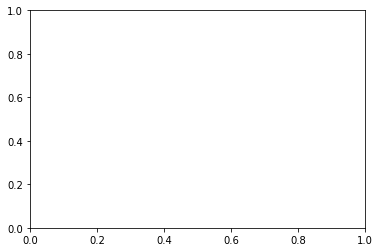

In [30]:
# Plot features using predictions to color datapoints
#Rødt er predicted til å være vei
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

In [96]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

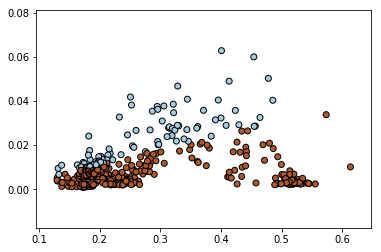

In [97]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

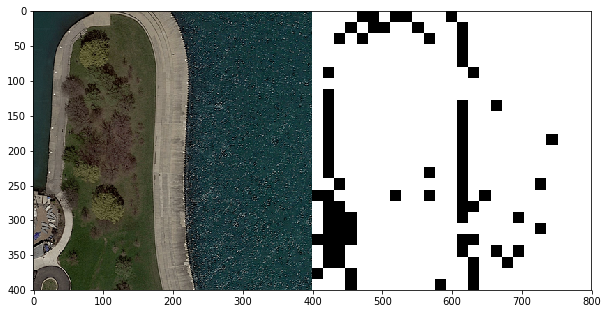

In [82]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')




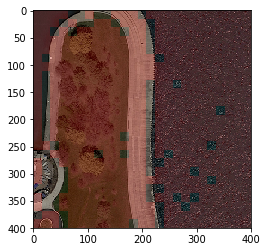

In [83]:
new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)